## Image Caption Generator 
In this project we will generate textual captions of images using deep learning model involving CNN and LSTM. We will build an image caption generator which will recieve an image as input and produce a caption describing the image.

Dataset used:

- The dataset contains around 30000 random images and text captions for each image: https://www.kaggle.com/datasets/adityajn105/flickr8k

### Problem Statement

The objective of the image-to-caption Python project is to construct a machine learning model capable of automatically producing descriptive and informative captions for images. With the aid of an input image, the model will be equipped to scrutinize its contents meticulously and compose a natural language caption that precisely depicts the image's content and context. The resultant captions must be both meaningful and succinct, while being devoid of grammatical errors. 

The captions must also effectively capture the crux of the image, expressed in a manner that is comprehensible to humans. The proposed system can be of great benefit in various applications, including but not limited to, image indexing, content-based image retrieval, and automated image captioning for individuals with visual impairments.

In [113]:
#Import the necessary libraries first
import random
import string

import cv2
import os

import nltk
from nltk.corpus import stopwords
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.optimizers import Adam
from PIL import Image
import cv2

In [151]:
from pickle import dump, load
from keras.layers import concatenate
from keras.applications.xception import Xception, preprocess_input
from keras.utils import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

#### Importing the dataset

In [115]:
file = open("captions.txt", "r")

In [116]:
text = file.read()

In [117]:
captions = text.split('\n')

In [118]:
captions

['image,caption',
 '1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .',
 '1000268201_693b08cb0e.jpg,A girl going into a wooden building .',
 '1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .',
 '1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .',
 '1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting',
 '1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .',
 '1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .',
 '1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .',
 '1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .',
 '1002674143_1b742ab4b8.jpg,A little girl covered in paint sits in front of a painted rainbow wi

In [119]:
descriptions ={}
for caption in captions[1:-1]:
    img, caption = caption.split(',', maxsplit =1)
    if img[:-2] not in descriptions:
        descriptions[img[:-2]] = [ caption ]
    else:
        descriptions[img[:-2]].append(caption)
print(descriptions)

{'1000268201_693b08cb0e.j': ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .'], '1001773457_577c3a7d70.j': ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .'], '1002674143_1b742ab4b8.j': ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There is a girl with pigtails s

In [120]:
descriptions.keys()

dict_keys(['1000268201_693b08cb0e.j', '1001773457_577c3a7d70.j', '1002674143_1b742ab4b8.j', '1003163366_44323f5815.j', '1007129816_e794419615.j', '1007320043_627395c3d8.j', '1009434119_febe49276a.j', '1012212859_01547e3f17.j', '1015118661_980735411b.j', '1015584366_dfcec3c85a.j', '101654506_8eb26cfb60.j', '101669240_b2d3e7f17b.j', '1016887272_03199f49c4.j', '1019077836_6fc9b15408.j', '1019604187_d087bf9a5f.j', '1020651753_06077ec457.j', '1022454332_6af2c1449a.j', '1022454428_b6b660a67b.j', '1022975728_75515238d8.j', '102351840_323e3de834.j', '1024138940_f1fefbdce1.j', '102455176_5f8ead62d5.j', '1026685415_0431cbf574.j', '1028205764_7e8df9a2ea.j', '1030985833_b0902ea560.j', '103106960_e8a41d64f8.j', '103195344_5d2dc613a3.j', '103205630_682ca7285b.j', '1032122270_ea6f0beedb.j', '1032460886_4a598ed535.j', '1034276567_49bb87c51c.j', '104136873_5b5d41be75.j', '1042020065_fb3d3ba5ba.j', '1042590306_95dea0916c.j', '1045521051_108ebc19be.j', '1048710776_bb5b0a5c7c.j', '1052358063_eae6744153.j'

#### Data cleaning- lower casing, removing puntuations and words containing numbers

In [52]:
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a 
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

#### Building Vocabulary

In [53]:
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab
#All descriptions in one file 

In [54]:
#All descriptions in one file 
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [55]:
#cleaning the descriptions
clean_descriptions = cleaning_text(descriptions)

In [56]:
clean_descriptions

{'1000268201_693b08cb0e.j': ['child in pink dress is climbing up set of stairs in an entry way',
  'girl going into wooden building',
  'little girl climbing into wooden playhouse',
  'little girl climbing the stairs to her playhouse',
  'little girl in pink dress going into wooden cabin'],
 '1001773457_577c3a7d70.j': ['black dog and spotted dog are fighting',
  'black dog and tricolored dog playing with each other on the road',
  'black dog and white dog with brown spots are staring at each other in the street',
  'two dogs of different breeds looking at each other on the road',
  'two dogs on pavement moving toward each other'],
 '1002674143_1b742ab4b8.j': ['little girl covered in paint sits in front of painted rainbow with her hands in bowl',
  'little girl is sitting in front of large painted rainbow',
  'small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it',
  'there is girl with pigtails sitting in front of rainbow painting',
  'young girl w

In [57]:
vocab = text_vocabulary(clean_descriptions)
print("Vocab Length = ", len(vocab))

Vocab Length =  8763


In [58]:
vocab

{'snarls',
 'discovery',
 'scraping',
 'hazmat',
 'shoulderdeep',
 'bug',
 'direction',
 'amphitheater',
 'level',
 'feather',
 'flexing',
 'peak',
 'nerf',
 'snuggling',
 'arabian',
 'applauding',
 'stoop',
 'gesture',
 'twos',
 'cupcake',
 'vessel',
 'change',
 'cameras',
 'freak',
 'paraphernalia',
 'assorted',
 'made',
 'signage',
 'down',
 'greet',
 'frosting',
 'exploring',
 'uplifted',
 'burning',
 'creates',
 'sash',
 'aided',
 'trick',
 'drove',
 'lighterskinned',
 'pinkhooded',
 'youn',
 'blurry',
 'od',
 'scrimmage',
 'sunny',
 'diner',
 'nordic',
 'diagram',
 'paleontologist',
 'jumpropes',
 'nipping',
 'entitled',
 'dribbling',
 'roasted',
 'moutain',
 'stripe',
 'pudding',
 'biscut',
 'skydiving',
 'skii',
 'cavern',
 'somthing',
 'jogger',
 'hunched',
 'playground',
 'leashes',
 'fences',
 'gothic',
 'concentrates',
 'graffitiheavy',
 'sportswear',
 'wetsuits',
 'straining',
 'chute',
 'swimcap',
 'enjoying',
 'thirds',
 'handwritten',
 'outcropping',
 'factory',
 'roadw

In [59]:
save_descriptions(clean_descriptions, "descriptions.txt")

In [60]:
file = open('descriptions.txt', 'r')

In [62]:
import pandas as pd

In [70]:
df

,1000268201_693b08cb0e.j,child in pink dress is climbing up set of stairs in an entry way
0,1000268201_693b08cb0e.j,girl going into wooden building
1,1000268201_693b08cb0e.j,little girl climbing into wooden playhouse
2,1000268201_693b08cb0e.j,little girl climbing the stairs to her playhouse
3,1000268201_693b08cb0e.j,little girl in pink dress going into wooden cabin
4,1001773457_577c3a7d70.j,black dog and spotted dog are fighting
...,...,...
40449,997722733_0cb5439472.j,man in pink shirt climbs rock face
40450,997722733_0cb5439472.j,man is rock climbing high in the air
40451,997722733_0cb5439472.j,person in red shirt climbing up rock face cove...
40452,997722733_0cb5439472.j,rock climber in red shirt


In [71]:
df.columns = ['A', 'B']

In [74]:
df

,A,B
0,1000268201_693b08cb0e.j,girl going into wooden building
1,1000268201_693b08cb0e.j,little girl climbing into wooden playhouse
2,1000268201_693b08cb0e.j,little girl climbing the stairs to her playhouse
3,1000268201_693b08cb0e.j,little girl in pink dress going into wooden cabin
4,1001773457_577c3a7d70.j,black dog and spotted dog are fighting
...,...,...
40449,997722733_0cb5439472.j,man in pink shirt climbs rock face
40450,997722733_0cb5439472.j,man is rock climbing high in the air
40451,997722733_0cb5439472.j,person in red shirt climbing up rock face cove...
40452,997722733_0cb5439472.j,rock climber in red shirt


In [76]:
df['A'] = df['A'] + 'pg'

In [77]:
df

,A,B
0,1000268201_693b08cb0e.jpg,girl going into wooden building
1,1000268201_693b08cb0e.jpg,little girl climbing into wooden playhouse
2,1000268201_693b08cb0e.jpg,little girl climbing the stairs to her playhouse
3,1000268201_693b08cb0e.jpg,little girl in pink dress going into wooden cabin
4,1001773457_577c3a7d70.jpg,black dog and spotted dog are fighting
...,...,...
40449,997722733_0cb5439472.jpg,man in pink shirt climbs rock face
40450,997722733_0cb5439472.jpg,man is rock climbing high in the air
40451,997722733_0cb5439472.jpg,person in red shirt climbing up rock face cove...
40452,997722733_0cb5439472.jpg,rock climber in red shirt


In [78]:
df.to_csv('descriptions_new.txt', sep=' ', index=False)

#### Model Selection - Transfer Learning
Using Xception Model and extracting the important features

In [121]:
# small library for seeing the progress of loops.
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()

C:\Users\User\AppData\Local\Temp\ipykernel_16352\3161688978.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [19]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img] = feature
        return features
#2048 feature vector

In [20]:
dataset_images = "Images"

In [21]:
tqdm(os.listdir(dataset_images)).total

C:\Users\User\AppData\Local\Temp\ipykernel_16352\2956261889.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm(os.listdir(dataset_images)).total


  0%|          | 0/8091 [00:00<?, ?it/s]

8091

In [22]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img] = feature
        return features

#### Feature Extraction

In [ ]:
#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("features.p","wb"))

In [122]:
features = load(open("features.p","rb"))

In [123]:
import shutil

In [31]:
# Set the source folder where the images are located
src_folder = "copy_images"

# Set the destination folder where the selected images will be moved
dst_folder = "training_set"

# Set the maximum number of images to select
max_images = 6000

# Create the destination folder if it doesn't exist
if not os.path.exists(dst_folder):
    os.makedirs(dst_folder)

# Initialize a counter to keep track of the number of selected images
count = 0

# Loop through all the files in the source folder
for filename in os.listdir(src_folder):
    # Check if the file is an image (you can modify this check to include only certain types of images)
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Copy the image file to the destination folder
        shutil.move(os.path.join(src_folder, filename), dst_folder)
        # Increment the counter
        count += 1
        # Break the loop if the maximum number of images has been reached
        if count == max_images:
            break

print(f"{count} images have been moved to {dst_folder}.")

6000 images have been moved to testing_set.


In [106]:
training_caption = df.head(35440)

In [107]:
training_caption

,0,1
0,1000268201_693b08cb0e.jpg,child in pink dress is climbing up set of stai...
1,1000268201_693b08cb0e.jpg,girl going into wooden building
2,1000268201_693b08cb0e.jpg,little girl climbing into wooden playhouse
3,1000268201_693b08cb0e.jpg,little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,little girl in pink dress going into wooden cabin
...,...,...
35435,3767841911_6678052eb6.jpg,baby girl in an orange dress gets wet as she s...
35436,3767841911_6678052eb6.jpg,blonde toddler wearing an orange dress is wet ...
35437,3767841911_6678052eb6.jpg,child in dress is looking at sprinkler
35438,3767841911_6678052eb6.jpg,little girl in an orange dress is running thro...


In [110]:
start_index = 35440
#end_index = 
testing_caption = df.iloc[start_index:, :]

In [111]:
df

,0,1
0,1000268201_693b08cb0e.jpg,child in pink dress is climbing up set of stai...
1,1000268201_693b08cb0e.jpg,girl going into wooden building
2,1000268201_693b08cb0e.jpg,little girl climbing into wooden playhouse
3,1000268201_693b08cb0e.jpg,little girl climbing the stairs to her playhouse
4,1000268201_693b08cb0e.jpg,little girl in pink dress going into wooden cabin
...,...,...
40450,997722733_0cb5439472.jpg,man in pink shirt climbs rock face
40451,997722733_0cb5439472.jpg,man is rock climbing high in the air
40452,997722733_0cb5439472.jpg,person in red shirt climbing up rock face cove...
40453,997722733_0cb5439472.jpg,rock climber in red shirt


In [140]:
testing_caption

35440    377872472_35805fc143.jpg
35441    377872472_35805fc143.jpg
35442    377872472_35805fc143.jpg
35443    377872472_35805fc143.jpg
35444    377872472_35805fc143.jpg
                   ...           
40450    997722733_0cb5439472.jpg
40451    997722733_0cb5439472.jpg
40452    997722733_0cb5439472.jpg
40453    997722733_0cb5439472.jpg
40454    997722733_0cb5439472.jpg
Name: 0, Length: 5015, dtype: object

In [141]:
training_caption = training_caption[0]

In [142]:
training_caption

0        1000268201_693b08cb0e.jpg
1        1000268201_693b08cb0e.jpg
2        1000268201_693b08cb0e.jpg
3        1000268201_693b08cb0e.jpg
4        1000268201_693b08cb0e.jpg
                   ...            
35435    3767841911_6678052eb6.jpg
35436    3767841911_6678052eb6.jpg
35437    3767841911_6678052eb6.jpg
35438    3767841911_6678052eb6.jpg
35439    3767841911_6678052eb6.jpg
Name: 0, Length: 35440, dtype: object

In [124]:
#load the data 
def load_photos(filename='training_set'):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

In [125]:
def load_doc(filename):
    # Opening the file as read only
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [126]:
def load_clean_descriptions(filename, photos): 
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

In [127]:
def load_features(photos):
    #loading all features
    all_features = load(open("features.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [ ]:
training_caption.to_csv('training_caption.txt', index=False)

In [144]:
testing_caption.to_csv('testing_caption.txt', index=False)

In [128]:
filename = "training_caption.txt"

In [131]:
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions_new.txt", train_imgs)
train_features = load_features(train_imgs)

In [132]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

In [133]:
#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary
from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [134]:
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8282

In [136]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
max_length

38

In [137]:
#create input-output sequence pairs from the image description.
#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

In [138]:
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

In [87]:
from keras.utils import plot_model
# define the captioning model
def define_model(vocab_size, max_length):
    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [165]:
#img_path = "C:\\Users\\User\\Downloads\\image0.jpeg"
#img_path = "C:\\Users\\User\\Downloads\\WhatsApp Image 2023-03-28 at 5.06.38 PM.jpeg"
#img_path = "C:\\Users\\User\\Downloads\\math_dl2_project\\testing_set\\537225246_dd0e2158a7.jpg"

img_path = "C:\\Users\\User\\Downloads\\math_dl2_project\\testing_set\\428483413_b9370baf72.jpg"

1/1 [==============================] - 3s 3s/step



start man in brown shirt is front on area end


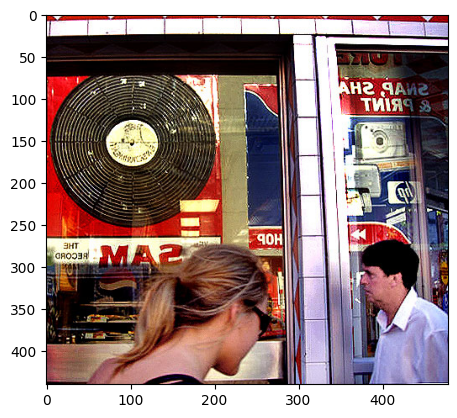

In [166]:
def extract_features(filename, model):
        try:
            image = Image.open(filename)
        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299,299))
        image = np.array(image)
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/127.5
        image = image - 1.0
        feature = model.predict(image)
        return feature
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

max_length = 32
tokenizer = pickle.load(open("tokenizer.p","rb"))
model = load_model("C:\\Users\\User\\Downloads\\model_9.h5")
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)

### Conclusion

Overall we were successfully able to build the model and test it, however the results were not quite what we expected as our systems didn't have GPU's so it took around 9-10 hours for a single run to train our model. Going forward, we will try to include google colab and kaggle, however the dataset being 1 GB was taking a long time to upload. But we are still working on improving/ tuning the model and deriving better results.

### Future Scope


There are several possible future enhancements that can be made to the image-to-caption Python project:
1. Multi-lingual support: Currently, the project generates captions only in English. In the future, the system can be expanded to support captions in multiple languages, making it useful for a broader range of users.
2. Image understanding: The system can be enhanced to not only identify the objects in an image but also understand the relationship between them. This would enable the system to generate captions that not only describe the content of the image but also convey the story or narrative behind it.
3. Personalization: The system can be customized to generate captions that reflect the preferences of individual users. For example, the system can learn from the user's previous interactions with it and generate captions that are tailored to their interests.
4. Improved accuracy: While the current system is capable of generating reasonably accurate captions, there is always room for improvement. The system can be trained on larger datasets, and more advanced machine learning techniques can be employed to enhance the accuracy of the generated captions.
5. Integration with other applications: The system can be integrated with other applications such as social media platforms, e-commerce websites, and news portals, where it can automatically generate captions for images posted on these platforms. This would make the system even more useful and relevant to a broader range of users.


## Summary

The image to caption Python project uses a combination of LSTM (Long Short-Term Memory) and CNN (Convolutional Neural Network) models to generate descriptive captions for images. The CNN model is used to extract the features of the input image, while the LSTM model is used to generate the corresponding caption by predicting the most probable sequence of words given the input image features. The project involves training the LSTM and CNN models on a large dataset of images and corresponding captions. The LSTM model uses a technique called "teacher forcing" to improve its training by feeding in the actual caption words during training instead of its own predicted words. Once the models are trained, they can be used to generate captions for new images by passing the image through the CNN model to extract its features, and then using the LSTM model to generate the corresponding caption. The resulting captions are generally coherent, meaningful, and accurate.

### References

https://github.com/masumahmedeesha/Image-Caption-Generator

https://youtu.be/yWAhC95n5RM

https://www.kaggle.com/datasets/adityajn105/flickr8k?select=Images